# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [33]:
import numpy as np 
import pandas as pd  
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

%matplotlib inline

Прочитаем исходные данные:

In [2]:
df = pd.read_csv('D:\\ds\\mipt\\unconv.csv')
df.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [4]:
features = df.columns.drop(['Well', 'Prod'])
nrows = 2
ncols = 3

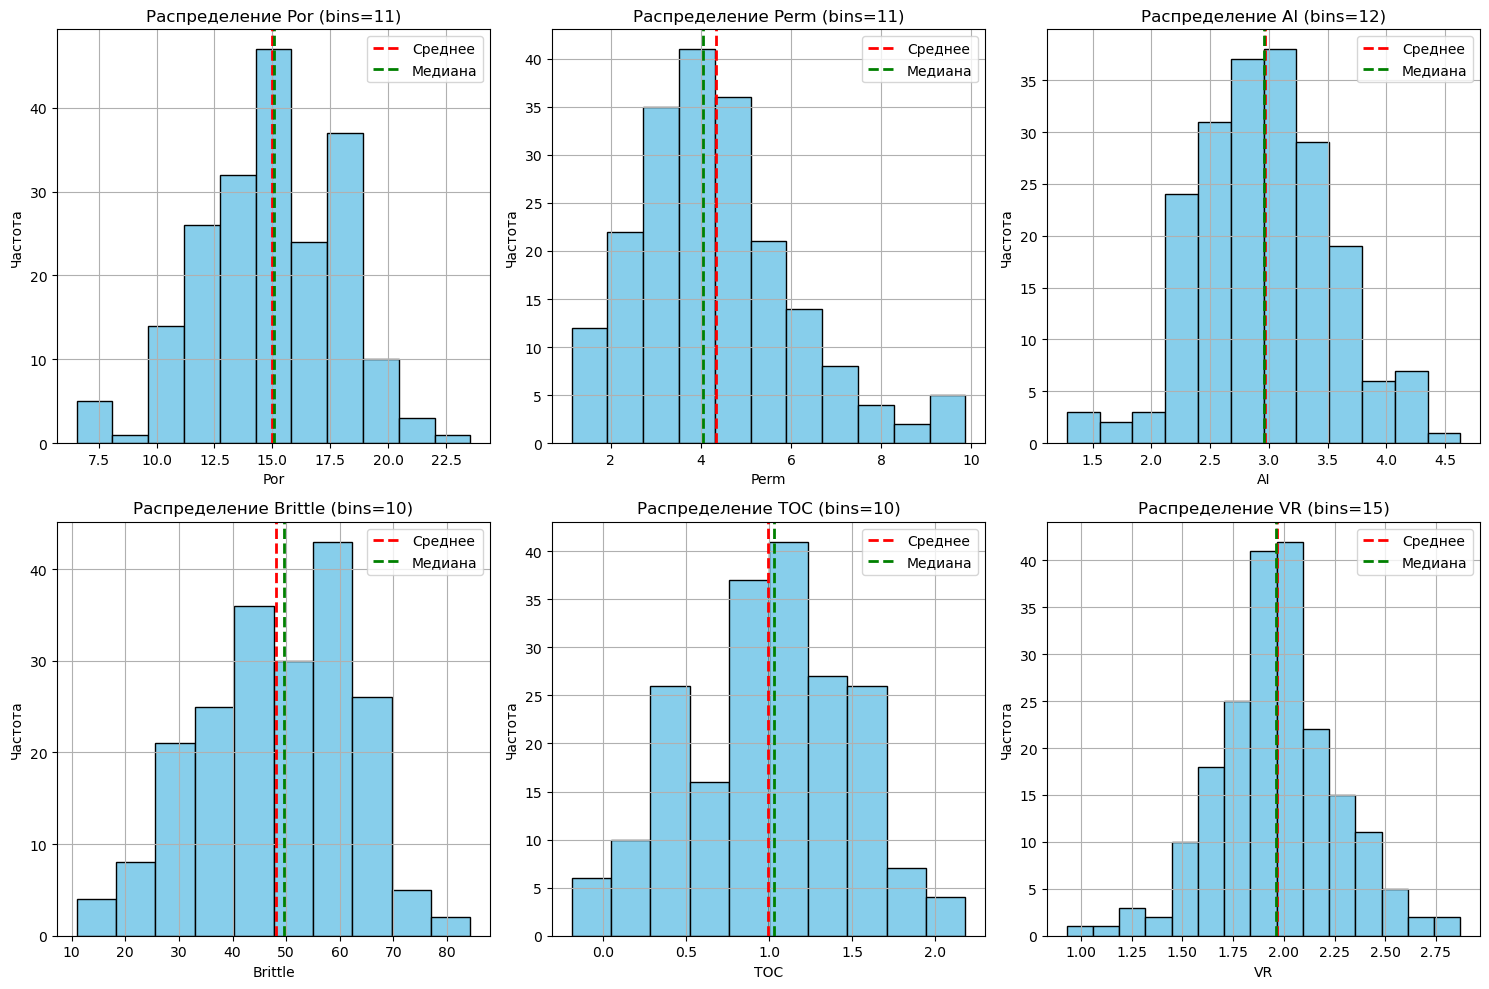

In [6]:
def calculate_bins(data):
    """Функция для расчета оптимального количества бинов."""
    q75, q25 = np.percentile(data, [75, 25])  
    iqr = q75 - q25  
    bin_width = 2 * iqr * len(data) ** (-1 / 3)  
    bins = int((data.max() - data.min()) / bin_width)  
    return max(10, bins)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i, feature in enumerate(features):
    data = df[feature]
    bins = calculate_bins(data)
    mean_value = data.mean()
    median_value = data.median()
    axs[i // ncols, i % ncols].hist(
        data, 
        bins=bins, 
        color='skyblue', 
        edgecolor='black')

    axs[i // ncols, i % ncols].axvline(
        mean_value, 
        color='red', 
        linestyle='dashed', 
        linewidth=2, 
        label='Среднее'
    )  
    axs[i // ncols, i % ncols].axvline(
        median_value, 
        color='green', 
        linestyle='dashed', 
        linewidth=2, 
        label='Медиана'
    ) 
    axs[i // ncols, i % ncols].set_title(f'Распределение {feature} (bins={bins})')
    axs[i // ncols, i % ncols].set_xlabel(feature)
    axs[i // ncols, i % ncols].set_ylabel('Частота')
    axs[i // ncols, i % ncols].grid(True)
    axs[i // ncols, i % ncols].legend() 

plt.tight_layout()
plt.show()

1. **Общая тенденция:**

    - На всех гистограммах медиана и среднее значение расположены либо очень близко, либо почти совпадают. Это свидетельствует о том, что распределения признаков имеют умеренное отклонение от       нормальности, что может указывать на стабильные характеристики в данных.<br><br>
2. **Проницаемость (Perm):**

    - Гистограмма проницаемости продемонстрировала наименее симметричное распределение среди всех признаков. Наличие правого хвоста указывает на наличие выбросов или более высоких значений, что может требовать дополнительного анализа, чтобы понять влияние этих значений на общую проницаемость.<br><br>
3. **Пористость (Por):**

    - Гистограмма пористости показала просадку справа сразу после центрального пика. Это может указывать на особенности геологического строения и потребовать дополнительного изучения в контексте влияния на добычу газа.<br><br>
3. **Общий углерод (TOC):**

    - Схожая просадка слева от центрального пика.

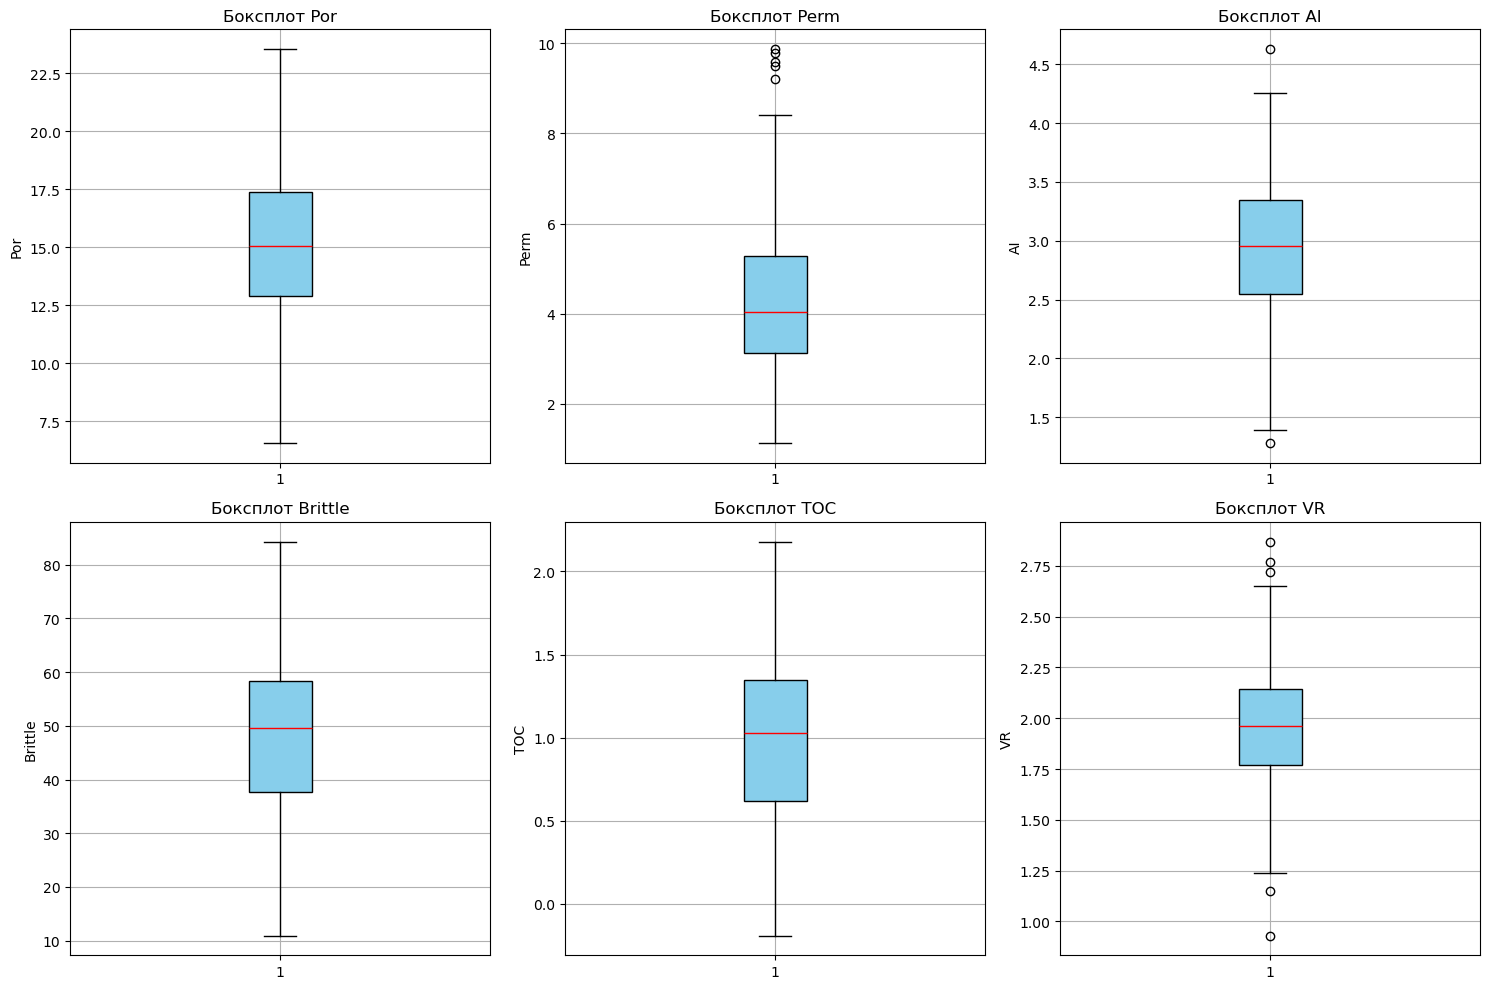

In [27]:
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(15, 10)
)
for i, feature in enumerate(features):
    axs[i // ncols, i % ncols].boxplot(
        df[feature], 
        patch_artist=True, 
        boxprops=dict(
            facecolor='skyblue', 
            color='black'),
        medianprops=dict(color='red'))
    axs[i // ncols, i % ncols].set_title(f'Боксплот {feature}')
    axs[i // ncols, i % ncols].set_ylabel(feature)
    axs[i // ncols, i % ncols].grid(True)

plt.tight_layout()
plt.show()

1. **Длина коробок**:
   - Коробки для всех признаков имеют приблизительно одинаковую длину, что указывает на схожий диапазон значений и вариацию данных в этих признаках.<br><br>

2. **Положение медианы**:
   - Медиана для большинства признаков находится близко к центру коробки. Это свидетельствует о относительно сбалансированном распределении значений, без сильных смещений.<br><br>

3. **Выбросы**:
   - Признак **Perm** демонстрирует наличие выбросов в верхней части распределения, что может указывать на наличие скважин с высокой проницаемостью, отличающихся от остальных и требующих более детального анализа.
   - Для признаков **AI** и **VR** наблюдаются выбросы как сверху, так и снизу. Это может свидетельствовать о наличии как высоких, так и низких значений акустического импеданса и коэффициента отражения витринита, что также требует внимания при интерпретации данных.

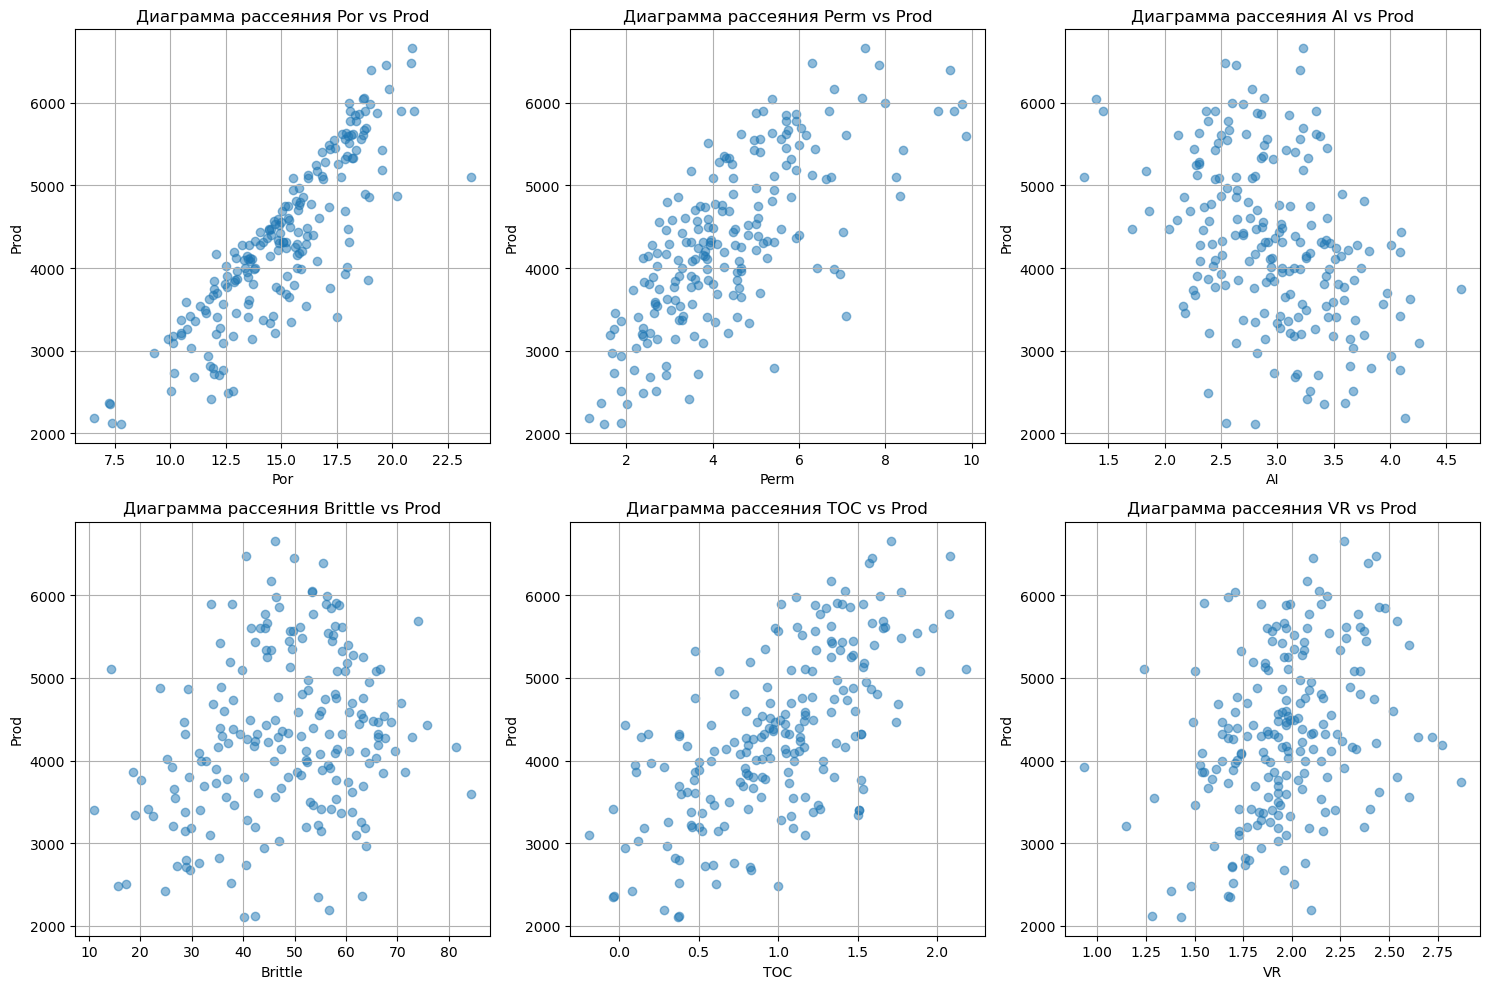

In [29]:
features = df.columns.drop(['Well'])

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i, feature in enumerate(features):
    if feature != 'Prod':
        axs[i // ncols, i % ncols].scatter(df[feature], df['Prod'], alpha=0.5)
        axs[i // ncols, i % ncols].set_title(f'Диаграмма рассеяния {feature} vs Prod')
        axs[i // ncols, i % ncols].set_xlabel(feature)
        axs[i // ncols, i % ncols].set_ylabel('Prod')
        axs[i // ncols, i % ncols].grid(True)

plt.tight_layout()  
plt.show()

На первый взгляд целевой признак более всего коррелирует с пористостью и проницаемостью.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

             Well       Por      Perm        AI   Brittle       TOC        VR  \
Well     1.000000  0.068927  0.077928  0.041483 -0.079252  0.022624 -0.007279   
Por      0.068927  1.000000  0.760546 -0.461549 -0.218570  0.711831  0.111860   
Perm     0.077928  0.760546  1.000000 -0.239636 -0.124017  0.471746  0.051023   
AI       0.041483 -0.461549 -0.239636  1.000000  0.127599 -0.531864  0.499143   
Brittle -0.079252 -0.218570 -0.124017  0.127599  1.000000 -0.214282  0.317929   
TOC      0.022624  0.711831  0.471746 -0.531864 -0.214282  1.000000  0.299483   
VR      -0.007279  0.111860  0.051023  0.499143  0.317929  0.299483  1.000000   
Prod     0.026817  0.861910  0.727426 -0.390835  0.237155  0.654445  0.323182   

             Prod  
Well     0.026817  
Por      0.861910  
Perm     0.727426  
AI      -0.390835  
Brittle  0.237155  
TOC      0.654445  
VR       0.323182  
Prod     1.000000  


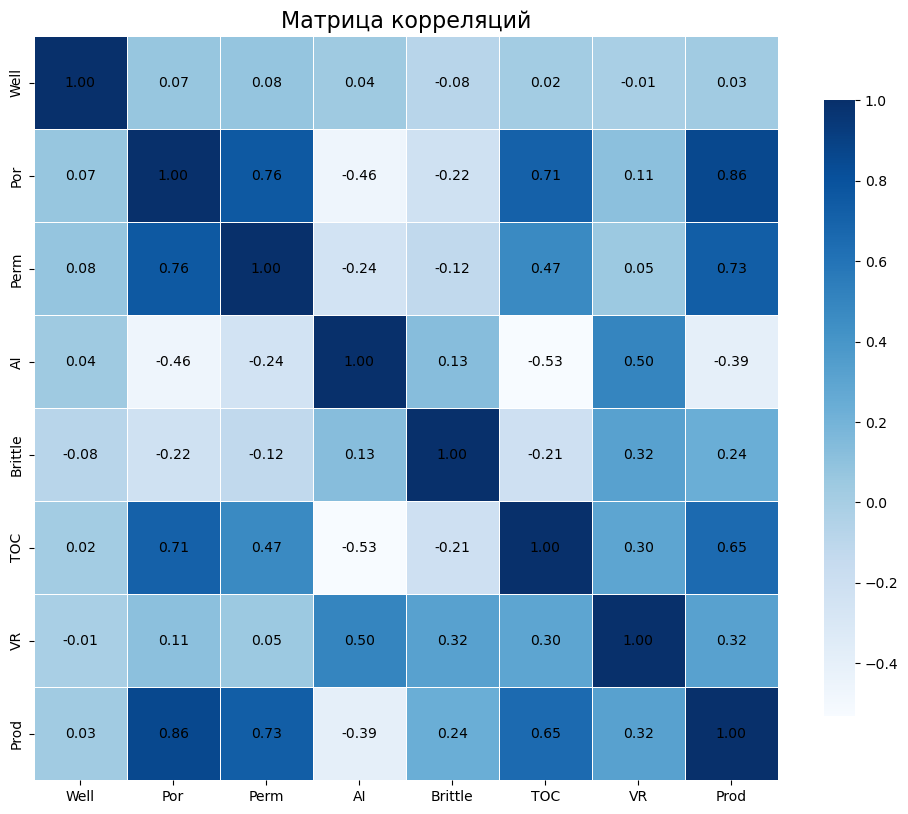

In [125]:
correlation_matrix = df.corr()
print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    cmap='Blues', 
    square=True, 
    cbar_kws={"shrink": .8}, 
    linewidths=0.5, 
    annot=False
)  
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j + 0.5, i + 0.5, 
                 f'{correlation_matrix.iloc[i, j]:.2f}', 
                 ha='center', va='center', fontsize=10, color='black')

plt.title('Матрица корреляций', size=16)
plt.show()

In [127]:
rank = np.linalg.matrix_rank(correlation_matrix)
det = np.linalg.det(correlation_matrix)
print(f'Ранг корреляционной матрицы: {rank}')
print(f'Определитель корреляционной матрицы: {det:.4f}')

Ранг корреляционной матрицы: 8
Определитель корреляционной матрицы: 0.0007


1. **Какие факторы сильнее всего коррелируют с целевой переменной?**

С целевой переменной (выработка газа, Prod) сильнее всего коррелируют следующие факторы:

- **Пористость (Por)**: коэффициент корреляции 0.861910.
- **Проницаемость (Perm)**: коэффициент корреляции 0.727426.
- **Общий органический углерод (TOC)**: коэффициент корреляции 0.654445.<br><br>

2. **Является ли корреляционная матрица плохо обусловленной (близок ли её определитель к нулю)?**

Да, корреляционная матрица является плохо обусловленной, так как её определитель равен 0.0007, что является малым значением.  В контексте линейной алгебры это означает, что матрица имеет низкую устойчивость, и малые изменения в входных данных могут приводить к значительным изменениям в выходных данных. Матрица близка к вырожденной, и в данных могут присутствовать признаки мультиколлинеарности.<br><br>

3. **Что вы можете сказать о наличии коллинеарности/мультиколлинеарности в данных?**

Мультиколлинеарность присутствует, поскольку несколько признаков имеют высокую корреляцию между собой. Например:
- **Пористость (Por)** и **Проницаемость (Perm)** имеют корреляцию 0.760546.
- **Пористость (Por)** и **TOC** коррелируют на уровне 0.711831.<br>

Высокая корреляция между признаками указывает на потенциальную мультиколлинеарность, что может затруднять точное оценивание коэффициентов регрессии в модели линейной регрессии.<br><br>

4. **Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему?**

Модель классической линейной регрессии может быть не вполне применима из-за наличия мультиколлинеарности. При мультиколлинеарности оценка коэффициентов линейной регрессии становится нестабильной: небольшие изменения в данных могут приводить к большим изменениям в коэффициентах. В такой ситуации методы регуляризации, такие как Ridge или Lasso, могут помочь решить проблему мультиколлинеарности, так как они добавляют штрафы за величину коэффициентов и стабилизируют модель.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [144]:
X = df.drop(columns=['Well', 'Prod'])
X = np.column_stack((np.ones(X.shape[0]), X))
y = df['Prod']
w_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Коэффициенты линейной регрессии:\n", np.round(w_hat))

Коэффициенты линейной регрессии:
 [-1230.   230.   116.  -364.    25.   -77.   783.]


#### 1. Оценка информативности признаков

При анализе коэффициентов линейной регрессии мы можем выявить признаки, которые, согласно модели, можно считать неинформативными. Поскольку все коэффициенты, кроме первого, не равны нулю, их значения указывают на влияние соответствующих признаков на целевую переменную (добыча газа, `Prod`). Однако, коэффициенты с небольшими абсолютными значениями могут свидетельствовать о незначительном влиянии:

- **Коэффициенты, близкие к нулю**: 
  - `25` и `-77` могут указывать на слабую связь с целевой переменной, что предполагает, что соответствующие признаки могут быть менее информативными или даже шумовыми.

Это означает, что при наличии более надежных методов отбора признаков можно рассмотреть возможность исключения этих переменных из модели.

#### 2. Интерпретация коэффициентов модели

- **Коэффициент 230**: 
  - Это значение указывает на то, что при увеличении соответствующего признака на 1 (например, пористость `Por`) ожидается увеличение добычи газа на 230 млн. кубических футов в сутки, при условии, что все остальные признаки остаются неизменными. Это значительное положительное влияние предполагает, что повышение пористости может существенно увеличить добычу газа.<br><br>

- **Коэффициент -364**:
  - Этот коэффициент подразумевает, что увеличение значения соответствующего признака (например, коэффициент хрупкости `Brittle`) на 1 приведет к снижению добычи газа на 364 млн. кубических футов в сутки, при прочих равных условиях. Отрицательное значение указывает на обратную зависимость, что может свидетельствовать о том, что более высокий коэффициент хрупкости может негативно сказаться на продуктивности скважины.<br><br>

- **Коэффициент 783**:
  - Этот коэффициент указывает на то, что увеличение соответствующего признака (например, общий органический углерод `TOC`) на 1 приводит к увеличению добычи газа на 783 млн. кубических футов в сутки. Это свидетельствует о том, что более высокий уровень органического углерода положительно влияет на добычу газа, что делает этот признак информативным.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [149]:
coeffs = np.array([230, 116, -364, 25, -77, 783])
input_data = np.array([15.32, 3.71, 3.29, 55.99, 1.35, 2.42])
predicted_prod = np.dot(coeffs, input_data)
actual_prod = 4748.315024
absolute_error = abs(actual_prod - predicted_prod)
print(f'Прогноз выработки газа для скважины: {predicted_prod:.0f} млн. кубических футов в сутки')
print(f'Абсолютная ошибка: {absolute_error:.2f} млн. кубических футов в день')

Прогноз выработки газа для скважины: 5947 млн. кубических футов в сутки
Абсолютная ошибка: 1198.74 млн. кубических футов в день


Для оценки качества регрессионной модели можно использовать несколько метрик:

1. **Средняя абсолютная ошибка (MAE, Mean Absolute Error)** — среднее значение абсолютных ошибок между предсказанными и фактическими значениями. MAE показывает, насколько в среднем ошибается модель в абсолютных значениях.<br><br>
  
2. **Среднеквадратичная ошибка (MSE, Mean Squared Error)** — среднее значение квадратов ошибок. MSE более чувствителен к большим ошибкам, поскольку он возводит ошибки в квадрат.

In [150]:
actual_prod = df['Prod'].values
mae = np.mean(np.abs(predicted_prod - actual_prod))
mse = np.mean((predicted_prod - actual_prod) ** 2)
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} млн. кубических футов в день')
print(f'Среднеквадратичная ошибка (MSE): {mse:.2f} млн. кубических футов в день')

Средняя абсолютная ошибка (MAE): 1663.07 млн. кубических футов в день
Среднеквадратичная ошибка (MSE): 3655192.50 млн. кубических футов в день


### Оценка результатов:

1. **MAE: 1663.07 млн. кубических футов в день**
   - Это значение говорит о том, что в среднем модель ошибается на 1663.07 миллионов кубических футов в день. Чтобы понять, нормально это или нет, нужно сравнить это значение с диапазоном фактических значений выработки газа.<br><br>

2. **MSE: 3655192.50 млн. кубических футов в день**
   - Это значение отражает среднеквадратичную ошибку, которая чувствительна к большим ошибкам. Высокое значение MSE указывает на наличие значительных ошибок в некоторых предсказаниях. Как и в случае с MAE, это значение следует анализировать в контексте данных.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

### Коэффициенты линейной регрессии
```plaintext
[230.   116.  -364.    25.   -77.   783.]
```

### Корреляционная матрица
```plaintext
              Prod
Por      0.861910
Perm     0.727426
AI     -0.390835
Brittle  0.237155
TOC      0.654445
VR       0.323182
```

### Анализ противоречий между коэффициентами и корреляцией

1. **Коэффициент для `AI`**:
   - **Коэффициент**: 116
   - **Корреляция**: -0.390835
   - **Противоречие**: Здесь наблюдается противоречие, так как корреляция показывает, что `AI` имеет отрицательную связь с `Prod`, а коэффициент модели положительный.<br><br>

2. **Коэффициент для `Brittle`**:
   - **Коэффициент**: -364
   - **Корреляция**: 0.237155
   - **Противоречие**: Аналогично, коэффициент `Brittle` отрицательный, в то время как корреляция положительная.<br><br>

3. **Коэффициент для `VR`**:
   - **Коэффициент**: -77
   - **Корреляция**: 0.323182
   - **Противоречие**: Здесь также отрицательный коэффициент модели противоречит положительной корреляции.<br><br>

### Объяснение противоречий

1. **Мультиколлинеарность**:
   - Признаки могут быть коррелированы между собой, что приводит к нестабильности коэффициентов модели. Это означает, что факторы могут влиять друг на друга, и даже если один признак имеет положительную корреляцию с целевой переменной, его влияние может быть перекрыто другими признаками. Это может приводить к искажению знака коэффициента.<br><br>

2. **Нелинейные связи**:
   - Модель линейной регрессии предполагает линейные зависимости между переменными. Если между факторами и целевой переменной есть нелинейные зависимости, это также может приводить к неожиданным результатам.<br><br>

3. **Шумовые влияния**:
   - Некоторые факторы могут оказывать незначительное или шумовое влияние на целевую переменную. Если такие факторы не являются информативными, это также может приводить к искажению результата.<br><br>

4. **Ограниченность линейной модели**:
   - Линейная регрессия не всегда подходит для сложных данных, особенно если имеются взаимодействия между переменными. В этом случае более сложные модели (например, полиномиальная регрессия) могут быть более эффективными.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

### Определение сильно коррелированных факторов

- **Por** и **Perm** имеют корреляцию 0.760546.
- **Por** и **TOC** также имеют корреляцию 0.711831.

### Выбор факторов для сохранения

- **Por**: Корреляция с **Prod** = 0.861910
- **TOC**: Корреляция с **Prod** = 0.654445

Так как `Por` имеет более высокую корреляцию с `Prod`, оставляем его.

**Итак, исключим `TOC`.**

### Определение факторов с низкой корреляцией

Исключим факторы, корреляция которых с целевой переменной меньше 0.05:

- **Well**: Корреляция = 0.026817 (исключаем)

### Итог

Исключаем факторы **TOC**, **Perm** и **Well**.

In [180]:
X = df.drop(columns=['Perm', 'TOC','Well', 'Prod'])
y = df['Prod']
X_inter = np.hstack([np.ones((X.shape[0], 1)), X])

w_hat = np.linalg.inv(X_inter.T @ X_inter) @ (X_inter.T @ y)
predicted_prod = X_inter @ w_hat

mae = np.mean(np.abs(predicted_prod - y))
mse = np.mean((predicted_prod - y) ** 2)
mape = np.mean(np.abs((y - predicted_prod) / y)) * 100

print("Коэффициенты линейной регрессии:", np.round(w_hat))
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} млн. кубических футов в день')
print(f'Среднеквадратичная ошибка (MSE): {mse:.2f} млн. кубических футов в день')
print(f'Средняя абсолютная процентная ошибка (MAPE): {mape:.2f} %')

Коэффициенты линейной регрессии: [-1835.   293.  -200.    28.   517.]
Средняя абсолютная ошибка (MAE): 171.43 млн. кубических футов в день
Среднеквадратичная ошибка (MSE): 53660.85 млн. кубических футов в день
Средняя абсолютная процентная ошибка (MAPE): 4.04 %


### Интерпретация коэффициентов линейной регрессии

1. **Коэффициент для свободного члена (-1835)**:
   - Свободный член показывает, что при нулевых значениях всех факторов объём добычи газа составит -1835 миллионов кубических футов в день. Это значение не имеет физического смысла, но служит базовым уровнем для интерпретации остальных коэффициентов.<br><br>

2. **Коэффициент для `Por` (293)**:
   - Это значение указывает на то, что при увеличении пористости на 1 единицу, объём добычи газа увеличивается на 293 миллиона кубических футов в день, если все остальные факторы остаются неизменными.
   - Этот коэффициент подтверждает сильную положительную корреляцию между `Por` и целевой переменной `Prod`, что согласуется с ранее рассчитанным коэффициентом корреляции.<br><br>

3. **Коэффициент для `AI` (-200)**:
   - Отрицательное значение коэффициента означает, что при увеличении акустического импеданса на 1 единицу, объём добычи газа снижается на 200 миллионов кубических футов в день, если остальные факторы остаются неизменными.
   - Это также соответствует отрицательной корреляции между `AI` и `Prod`, что указывает на обратную зависимость между этими показателями.<br><br>


### Интерпретация значений метрик

1. **Средняя абсолютная ошибка (MAE = 171.43)**:
   - Значение MAE 171.43 млн кубических футов в день указывает на хорошее качество модели, так как среднее отклонение прогнозируемых значений от фактических существенно меньше по сравнению с предыдущими моделями.<br><br>

2. **Среднеквадратичная ошибка (MSE = 53,660.85)**:
   - Значение MSE 53,660.85 говорит о наличии определённых отклонений в прогнозах, но в целом модель демонстрирует улучшение по сравнению с исходными результатами.<br><br>

3. **Средняя абсолютная процентная ошибка (MAPE = 4.04%)**:
   - Значение MAPE 4.04% указывает на то, что ошибка модели в среднем составляет около 4% от фактических значений объёма добычи газа, что является отличным показателем точности прогноза.<br><br>

### Итог

Основные проблемы с коллинеарностью между факторами были успешно устранены. Коэффициенты линейной регрессии теперь логичны и соответствуют знакам их корреляции с целевой переменной. Модель демонстрирует высокое качество прогнозирования, что подтверждается низкими значениями MAE, MSE и MAPE.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [183]:
model = LinearRegression()

X = df.drop(columns=['Perm', 'TOC', 'Well', 'Prod'])
y = df['Prod']

model.fit(X, y)
predicted_prod = model.predict(X)

mae = mean_absolute_error(y, predicted_prod)
mse = mean_squared_error(y, predicted_prod)
mape = np.mean(np.abs((y - predicted_prod) / y)) * 100

cv_results = cross_validate(
    model, 
    X, 
    y, 
    scoring='neg_mean_absolute_percentage_error', 
    cv=5, 
    return_train_score=True
)
coeffs = np.round(model.coef_, 0)  
intercept = np.round(model.intercept_, 0)

print(f'Коэффициенты линейной регрессии: {coeffs}')
print(f'Свободный член: {intercept}')
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} млн. кубических футов в день')
print(f'Среднеквадратичная ошибка (MSE): {mse:.2f} млн. кубических футов в день')
print(f'Средняя абсолютная процентная ошибка (MAPE): {mape:.2f} %')
print('\nMAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))


Коэффициенты линейной регрессии: [ 293. -200.   28.  517.]
Свободный член: -1835.0
Средняя абсолютная ошибка (MAE): 171.43 млн. кубических футов в день
Среднеквадратичная ошибка (MSE): 53660.85 млн. кубических футов в день
Средняя абсолютная процентная ошибка (MAPE): 4.04 %

MAPE на тренировочных фолдах: 4.02 %
MAPE на валидационных фолдах: 4.23 %


### Сравнение результатов библиотечной реализации с ручной

#### 1. Коэффициенты линейной регрессии:
- **Библиотечная реализация**: 
  - Коэффициенты: \([293, -200, 28, 517]\)
  - Свободный член: \(-1835.0\)<br><br>

- **Ручная реализация**: 
  - Коэффициенты: \([293, -200, 28, 517]\)
  - Свободный член: \(-1835.0\)<br><br>

**Сравнение**: <br>
Коэффициенты в библиотечной реализации и ручной реализации совпадают по значениям и количеству. Оба подхода демонстрируют одинаковые результаты, что указывает на согласованность в вычислениях.

#### 2. Ошибки модели:
- **Библиотечная реализация**: 
  - Средняя абсолютная ошибка (MAE): \(171.43\) млн. кубических футов в день
  - Среднеквадратичная ошибка (MSE): \(53660.85\) млн. кубических футов в день
  - Средняя абсолютная процентная ошибка (MAPE): \(4.04\%\)<br><br>

- **Ручная реализация**: 
  - Средняя абсолютная ошибка (MAE): \(171.43\) млн. кубических футов в день
  - Среднеквадратичная ошибка (MSE): \(53660.85\) млн. кубических футов в день
  - Средняя абсолютная процентная ошибка (MAPE): \(4.04\%\)<br><br>

**Сравнение**:<br><br> 
1. **MAE**: 
   - Ручная реализация: \(171.43\) 
   - Библиотечная реализация: \(171.43\) 
   - Значения MAE полностью совпадают, что указывает на одинаковую производительность обеих моделей.<br><br>

2. **MSE**: 
   - Ручная реализация: \(53660.85\) 
   - Библиотечная реализация: \(53660.85\) 
   - Значения MSE также совпадают, что подтверждает идентичное качество моделей.<br><br>

3. **MAPE**: 
   - Ручная реализация: \(4.04\%\) 
   - Библиотечная реализация: \(4.04\%\) 
   - Значения MAPE идентичны, что говорит о схожести в точности прогнозирования.<br><br>

### Вывод
- В целом, результаты библиотечной реализации `sklearn` и ручной реализации `numpy` абсолютно идентичны как по коэффициентам, так и по метрикам качества.
- Это подтверждает, что оба подхода корректно моделируют данные, и могут быть использованы для прогнозирования выработки газа на основе имеющихся факторов.
- Полное совпадение результатов указывает на согласованность и правильность расчетов в обеих реализациях.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [176]:
scaler = StandardScaler()
model = LinearRegression()

X = df.drop(columns=['Perm', 'TOC','Well', 'Prod'])
y = df['Prod']
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled) 
model.fit(X_poly, y) 

cv_results = cross_validate(
    model, 
    X_poly, y, 
    scoring='neg_mean_absolute_percentage_error', 
    cv=5, 
    return_train_score=True
)

print(f'Количество факторов после генерации полиномиальных признаков:', X_poly.shape[1])
print(f'\nКоэффициенты: {model.coef_}')
print(f'\nСвободный член: {model.intercept_}')
print('\nMAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

Количество факторов после генерации полиномиальных признаков: 34

Коэффициенты: [ 9.45497734e+02 -1.11209300e+02  3.96560905e+02  1.32497358e+02
  9.80692299e+01  3.81275796e+01  1.91171366e+01 -3.64364921e+01
  9.76664182e+00  1.72565208e+00 -2.37499239e+01 -1.44568988e+02
  1.57117981e+00  8.50597004e+00 -1.15801458e+01 -4.23960463e+01
  5.38297602e+00  3.47349736e+01 -6.37593239e+00  1.35339186e+01
  3.72481021e+01 -8.33553192e+01  9.08176195e+00 -1.91786262e+01
  5.68556788e+00  1.52675003e+01  1.09648836e+01  1.64993264e+01
 -7.88497566e-01 -2.31669210e+01 -2.91595604e+01 -9.58205542e+00
  5.11900371e+00  3.56093046e+00]

Свободный член: 4372.941903669076

MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


### Выводы

1. **Количество факторов после генерации полиномиальных признаков: 34.**  
   После стандартизации и создания полиномиальных признаков третьей степени количество факторов значительно увеличилось благодаря добавлению взаимодействий между признаками, а также квадратов и кубов исходных признаков. Это позволяет модели более эффективно захватывать нелинейные зависимости.<br><br>

2. **Коэффициенты модели:**  
   - Положительный коэффициент при первом факторе (\(945.50\)) указывает на значительное влияние этого признака на целевую переменную: увеличение этого признака ведет к увеличению объема добычи газа.
   - Отрицательные коэффициенты (например, \(-111.21\) и \(-147.51\)) свидетельствуют о том, что увеличение этих факторов снижает прогнозируемую добычу газа.
   - Все коэффициенты интерпретируются в контексте стандартизированных данных, поэтому без обратной трансформации сложно сделать окончательные выводы о влиянии признаков в исходных единицах измерения.<br><br>

3. **Свободный член (\(4372.94\)).**  
   Это значение представляет собой базовое предсказание, если все факторы равны нулю после стандартизации. Оно устанавливает некий базовый уровень прогноза добычи газа.<br><br>

4. **MAPE на тренировочных и валидационных фолдах: 1.77 % и 2.68 %.**  
   - **MAPE на тренировочных данных (1.77%)**: эта метрика указывает на то, что в среднем модель ошибается на \(1.77\%\) при прогнозировании на тренировочных данных.
   - **MAPE на валидационных данных (2.68%)**: результаты на валидационной выборке несколько выше, но рост ошибки относительно тренировочных данных минимален, что свидетельствует о хорошем обобщении модели.<br><br>

### Общие выводы

- Полиномиальная регрессия успешно захватывает нелинейные зависимости между признаками, увеличивая количество факторов до 34.
- Модель не переобучена, поскольку ошибка на тренировочных и валидационных данных остается схожей.
- Низкие значения MAPE на тренировочных (1.77%) и валидационных (2.68%) фолдах указывают на высокую точность модели, что особенно важно для сложных данных.
- Ошибка в диапазоне 1.77%-2.68% свидетельствует о хорошем качестве прогноза, с возможностью дальнейшего улучшения за счет настройки гиперпараметров или добавления новых признаков.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [160]:
scaler = StandardScaler()
lasso = Lasso(max_iter=50000)

X = df.drop(columns=['Perm', 'TOC','Well', 'Prod'])
y = df['Prod']
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)  

alpha_values = np.logspace(-4, 4, 100)  
param_grid = {'alpha': alpha_values}

grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    return_train_score=True
)
grid_search.fit(X_poly, y)

best_alpha = grid_search.best_params_['alpha']
best_lasso = Lasso(alpha=best_alpha)
best_lasso.fit(X_poly, y)

cv_results = cross_validate(
    best_lasso, 
    X_poly, y, 
    scoring='neg_mean_absolute_percentage_error', 
    cv=5, 
    return_train_score=True
)

print(f'Лучшее значение alpha: {best_alpha}')
print(f'\nКоэффициенты модели: {best_lasso.coef_}')
print(f'\nСвободный член: {best_lasso.intercept_}')
print('\nMAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

Лучшее значение alpha: 4.862601580065354

Коэффициенты модели: [ 9.27535997e+02 -8.83307704e+01  3.75830576e+02  1.21255055e+02
  7.06934240e+01  0.00000000e+00  8.18569710e+00  0.00000000e+00
 -3.12160215e+00 -1.61246445e+00 -8.06151936e-01 -1.36367995e+02
  0.00000000e+00 -0.00000000e+00  2.72537132e+00 -1.51599578e+01
  4.15445723e+00  5.55645854e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -7.20192984e+01 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  5.36091358e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.44761962e+00 -1.95798252e+01  0.00000000e+00
  5.25359162e+00  0.00000000e+00]

Свободный член: 4380.176963901274

MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.28 %


1. **Коэффициенты модели:**  
   - Значения коэффициентов указывают на значительное сокращение их величин, при этом некоторые из них оказались обнулены. Это говорит о том, что Lasso успешно отсекает менее значимые признаки, что делает модель более компактной и устойчивой.<br><br>

2. **Свободный член:**  
   - Свободный член составил 4380.18 для модели с Lasso, что является небольшим изменением по сравнению с моделью без регуляризации (4338.81). Это различие может быть связано с тем, что регуляризация сжимает значения коэффициентов, внося небольшие коррективы в общий прогноз.<br><br>

3. **Качество модели (MAPE):**  
   - MAPE на тренировочных фолдах составила 1.83%, а на валидационных — 2.28%. Эти значения показывают, что модель с Lasso-регуляризацией достигает высокой точности прогноза как на тренировочных, так и на валидационных данных. Показатели MAPE указывают на отличное качество модели, особенно для сложных данных.<br><br>

### Общие выводы

- Внедрение Lasso-регуляризации привело к упрощению модели, что позволило избавиться от менее значимых признаков и улучшить ее устойчивость к переобучению.
- Низкие значения MAPE на тренировочных (1.83%) и валидационных (2.28%) фолдах свидетельствуют о высокой точности прогноза, что делает модель надежной для использования в задачах предсказания.
- Несмотря на то, что применение Lasso не привело к значительному улучшению по сравнению с моделью без регуляризации, оно всё же способствует уменьшению риска переобучения и позволяет более эффективно обрабатывать новые данные.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [164]:
scaler = StandardScaler()
ridge = Ridge(max_iter=50000)

X = df.drop(columns=['Perm', 'TOC','Well', 'Prod'])
y = df['Prod']
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)  

alpha_values = np.logspace(-4, 4, 100)  
param_grid = {'alpha': alpha_values}

grid_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    return_train_score=True
)
grid_search.fit(X_poly, y)

best_alpha = grid_search.best_params_['alpha']
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_poly, y)

cv_results = cross_validate(
    best_ridge, 
    X_poly, y, 
    scoring='neg_mean_absolute_percentage_error', 
    cv=5, 
    return_train_score=True
)

print(f'Лучшее значение alpha: {best_alpha}')
print(f'\nКоэффициенты модели: {best_ridge.coef_}')
print(f'\nСвободный член: {best_ridge.intercept_}')
print('\nMAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

Лучшее значение alpha: 0.20565123083486536

Коэффициенты модели: [ 9.32904078e+02 -1.17787973e+02  3.89138605e+02  1.39572057e+02
  9.63902836e+01  3.28528215e+01  1.82215196e+01 -3.04894658e+01
  7.05722214e+00 -6.83425600e-01 -1.89238968e+01 -1.44395111e+02
  3.82248271e+00  6.10966749e+00 -6.11799055e+00 -3.10185395e+01
  1.14755224e+01  2.50445806e+01  4.31439361e+00  2.29662244e+01
  1.95213807e+01 -7.80137485e+01 -9.96776774e-01 -1.17195101e+01
  8.87936883e+00  2.12518079e+01  2.83877358e+00  1.97058628e+01
 -1.20897287e+01 -1.57450342e+01 -2.72655691e+01 -1.35666027e+01
  1.07860707e+01  9.91700905e-01]

Свободный член: 4373.295603355892

MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.67 %


### Сравнение Lasso и Ridge:

1. **Сравнение коэффициентов:**  
   - Модель Lasso демонстрирует множество нулевых коэффициентов, что говорит о её способности отсеивать менее значимые признаки и упрощать модель. В отличие от этого, модель Ridge показывает более равномерное распределение коэффициентов, что говорит о том, что все признаки вносят вклад в предсказание, хотя и в разной степени.<br><br>

2. **Свободный член:**  
   - Свободные члены для моделей Lasso (4380.18) и Ridge (4373.30) немного отличаются, что указывает на различия в базовых предсказаниях, вызванные разным влиянием коэффициентов на итоговые значения.<br><br>

3. **Качество модели (MAPE):**  
   - **Lasso:** MAPE на тренировочных фолдах составила 1.83%, а на валидационных — 2.28%.  
   - **Ridge:** MAPE на тренировочных фолдах составила 1.77%, а на валидационных — 2.67%.  
   Оба метода показывают схожие результаты по метрике ошибки, однако Ridge демонстрирует немного меньшую ошибку на тренировочных данных, что может свидетельствовать о его большей устойчивости к переобучению. В то же время, Lasso показывает меньшую ошибку на валидационных данных, что может указывать на его лучшую способность к обобщению на новых данных.<br><br>

### Общие выводы:
- Оба метода регуляризации (Lasso и Ridge) приводят к сопоставимому качеству модели, показывая близкие результаты по метрике MAPE на тренировочных и валидационных данных.
- Lasso упрощает модель, зануляя некоторые коэффициенты и улучшая интерпретируемость, тогда как Ridge поддерживает более равномерное распределение весов, что может быть полезно, если все признаки значимы.
- На данном этапе ни один из методов не продемонстрировал значительного преимущества по снижению ошибки, однако выбор метода зависит от целей: Lasso предпочтителен для отбора признаков, в то время как Ridge подходит для ситуаций, когда необходимо сохранить все признаки в модели.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [171]:
scaler = StandardScaler()
elastic_net = ElasticNet(max_iter=10000)

X = df.drop(columns=['Perm', 'TOC', 'Well', 'Prod'])
y = df['Prod']
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

param_grid = {
    'alpha': np.linspace(0.001, 1, 10),  
    'l1_ratio': np.linspace(0.1, 0.9, 9)  
}
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_percentage_error', 
    return_train_score=True
)
grid_search.fit(X_poly, y)

best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']

best_elastic_net = ElasticNet(
    alpha=best_alpha, 
    l1_ratio=best_l1_ratio, 
    max_iter=10000
)
best_elastic_net.fit(X_poly, y)

cv_results = cross_validate(
    best_elastic_net,
    X_poly, y,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    return_train_score=True
)

print(f'Лучшее значение alpha: {best_alpha}')
print(f'Лучшее значение l1_ratio: {best_l1_ratio}')
print(f'\nКоэффициенты модели: {best_elastic_net.coef_}')
print(f'\nСвободный член: {best_elastic_net.intercept_}')
print('\nMAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))


Лучшее значение alpha: 0.001
Лучшее значение l1_ratio: 0.1

Коэффициенты модели: [ 9.34344043e+02 -1.17078287e+02  3.89966010e+02  1.38827620e+02
  9.65370617e+01  3.33495993e+01  1.82874536e+01 -3.10749944e+01
  7.29703511e+00 -4.56515408e-01 -1.93613113e+01 -1.44422791e+02
  3.61270772e+00  6.33348399e+00 -6.71216813e+00 -3.21792934e+01
  1.08370999e+01  2.60336746e+01  3.24852419e+00  2.20906240e+01
  2.12433914e+01 -7.86021135e+01  8.39340015e-04 -1.24518124e+01
  8.57268420e+00  2.06935199e+01  3.58019948e+00  1.93905280e+01
 -1.10201225e+01 -1.64249797e+01 -2.74778149e+01 -1.31649153e+01
  1.02329319e+01  1.23742348e+00]

Свободный член: 4373.2729828127385

MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.67 %


### Интерпретация результатов <br>

1. **MAPE на тренировочных фолдах:**
   - Значение MAPE на тренировочных фолдах составляет 1.77%. Это очень низкий уровень ошибки, что указывает на то, что модель хорошо подстраивается под тренировочные данные и делает довольно точные прогнозы на этой выборке.<br><br>

2. **MAPE на валидационных фолдах:**
   - Значение MAPE на валидационных фолдах составляет 2.67%. Это также низкий уровень ошибки, но он немного выше, чем на тренировочных данных. Это может указывать на то, что модель хорошо обобщается на новых данных, хотя и показывает небольшое ухудшение по сравнению с тренировочной выборкой.<br><br>

### Выводы:
- Модель ElasticNet демонстрирует хорошую производительность как на тренировочных, так и на валидационных данных, что подтверждается низкими значениями MAPE.
- Регуляризация через ElasticNet позволяет отбирать значимые признаки и минимизировать влияние менее значимых, что может помочь в повышении интерпретируемости модели.
- Наличие положительных и отрицательных коэффициентов указывает на разнообразие влияния факторов на целевую переменную, что позволяет лучше понимать, какие именно признаки и в какой степени влияют на добычу.<br><br>

В общем, результаты показывают, что модель ElasticNet адекватно справляется с задачей прогнозирования добычи на основе полиномиальных признаков, сохраняя высокую точность и интерпретируемость.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [184]:
data = {
    'Модель': [
        'Линейная регрессия',
        'Полиномиальная регрессия (3 степени)',
        'Lasso',
        'Ridge',
        'Elastic-Net'
    ],
    'Гиперпараметры': [
        '',
        '',
        'alpha: 4.86',
        'alpha: 0.21',
        'alpha: 0.001, l1_ratio: 0.1'
    ],
    'Полиномиальные признаки': [
        'Нет',
        'Да',
        'Да',
        'Да',
        'Да'
    ],
    'MAPE (тренировочные фолды)': [
        '4.02 %',
        '1.77 %',
        '1.83 %',
        '1.77 %',
        '1.77 %'
    ],
    'MAPE (валидационные фолды)': [
        '4.23 %',
        '2.68 %',
        '2.28 %',
        '2.67 %',
        '2.67 %'
    ]
}
results_df = pd.DataFrame(data)
display(results_df)

,Модель,Гиперпараметры,Полиномиальные признаки,MAPE (тренировочные фолды),MAPE (валидационные фолды)
0,Линейная регрессия,,Нет,4.02 %,4.23 %
1,Полиномиальная регрессия (3 степени),,Да,1.77 %,2.68 %
2,Lasso,alpha: 4.86,Да,1.83 %,2.28 %
3,Ridge,alpha: 0.21,Да,1.77 %,2.67 %
4,Elastic-Net,"alpha: 0.001, l1_ratio: 0.1",Да,1.77 %,2.67 %


### Вывод:

- **Линейная регрессия** имеет наименьшую разницу (0.21 %), что говорит о её относительно лучшей устойчивости к переобучению по сравнению с другими моделями, несмотря на то, что сама MAPE на валидационных фолдах для линейной регрессии выше.
- **Полиномиальная регрессия (3 степени)** показала наибольшую разницу (0.91 %), что указывает на её наиболее сильное переобучение.
- **Ridge** и **Elastic-Net** имеют схожие разницы около 0.90 %.<br><br>

Таким образом, линейная регрессия демонстрирует наименьшую разницу между тренировочными и валидационными фолдами, но это не означает, что она имеет лучшие показатели. Лучше всего себя показала модель **Lasso**, так как она достигла наименьшей MAPE на валидационных фолдах и разницы (0.45%) между фолдами.